# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model,
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering,
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering,
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [167]:
# !pip install h5py
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly


### Prepare Tissue Representations

Model, resnet50, pathologyGAN
Projection PCA, UMAP
Method KMeans, Louvain

Data            Metric
Test            Sihouette + Davies-Bouldin Index ==> need to Cross Validate to get good parameters
Label?          V-measure + Rand Index ==> show performance(model?), show similarity to test ones if YES -> we did use good parameters there

Parameters
1. k (number of cluster)

In [168]:
import h5py
import numpy as np
import pickle

In [169]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [170]:
vgg16_content

<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [171]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [172]:
vgg16_pca_feature

array([[ -90.864815 ,  107.03243  ,  116.16385  , ...,    8.259951 ,
          -1.1383446,   -9.175951 ],
       [ -74.06226  ,  117.31615  ,   95.24547  , ...,   -1.9739974,
           6.8172655,    4.2547903],
       [ -81.875336 ,  122.84872  ,   83.767784 , ...,   -1.3287221,
          13.65623  ,  -11.109545 ],
       ...,
       [  32.70835  ,   31.183935 ,  -47.30978  , ...,    4.2004256,
           3.599823 ,    6.0058775],
       [ -39.911785 , -105.81029  ,  122.37118  , ...,  -14.908715 ,
          -1.1814455,  -10.837135 ],
       [  32.35425  ,  -50.3373   ,   66.50197  , ...,   -3.859397 ,
          -1.047523 ,    2.3827858]], dtype=float32)

In [173]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [174]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])
labels

array(['ADI', 'ADI', 'ADI', ..., 'TUM', 'TUM', 'TUM'], dtype='<U4')

# Example

In [175]:
import random

In [176]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

In [177]:
test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [178]:
import plotly.graph_objects as go
import pandas as pd

In [179]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




### Model training

In [180]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain


In [181]:
#to create Adjacency matrix for  Louvain clustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler


In [182]:
kmeans_model = KMeans(n_clusters = 3, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
kmeans_assignment = kmeans_model.fit_predict(test_data)

/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [183]:
from scipy import sparse
louvain_model = Louvain(resolution = 0.9, modularity = 'Newman',random_state = 0)
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
louvain_assignment = louvain_model.fit_predict(adjacency_matrix)

### Evaluation and Visualisation

In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

* check out number of clusters/cluster assignment counts

In [185]:
print('Number of clusters from KMeans: %d and from Louvain: %d'%(np.unique(kmeans_assignment).shape[0],np.unique(louvain_assignment).shape[0]))

Number of clusters from KMeans: 3 and from Louvain: 3


In [186]:
kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
louvain_counts = np.unique(louvain_assignment, return_counts = True)

In [187]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,112
1,49
2,39


In [188]:
print('Louvain assignment counts')
pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index')

Louvain assignment counts


,Number of members
Cluster Index,
0,132
1,67
2,1


* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [189]:
kmeans_silhouette = silhouette_score(test_data, kmeans_assignment)
louvain_silhouette = silhouette_score(test_data, louvain_assignment)
kmeans_v_measure = v_measure_score(test_label, kmeans_assignment)
louvain_v_measure = v_measure_score(test_label, louvain_assignment)
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics')

,Kmeans,Louvain
Metrics,,
silhouette,0.198873,0.246675
V-measure,0.262987,0.270140


* Visualise tissue type percentage in two different clustering configurations

In [190]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_9489/3428919821.py:27: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



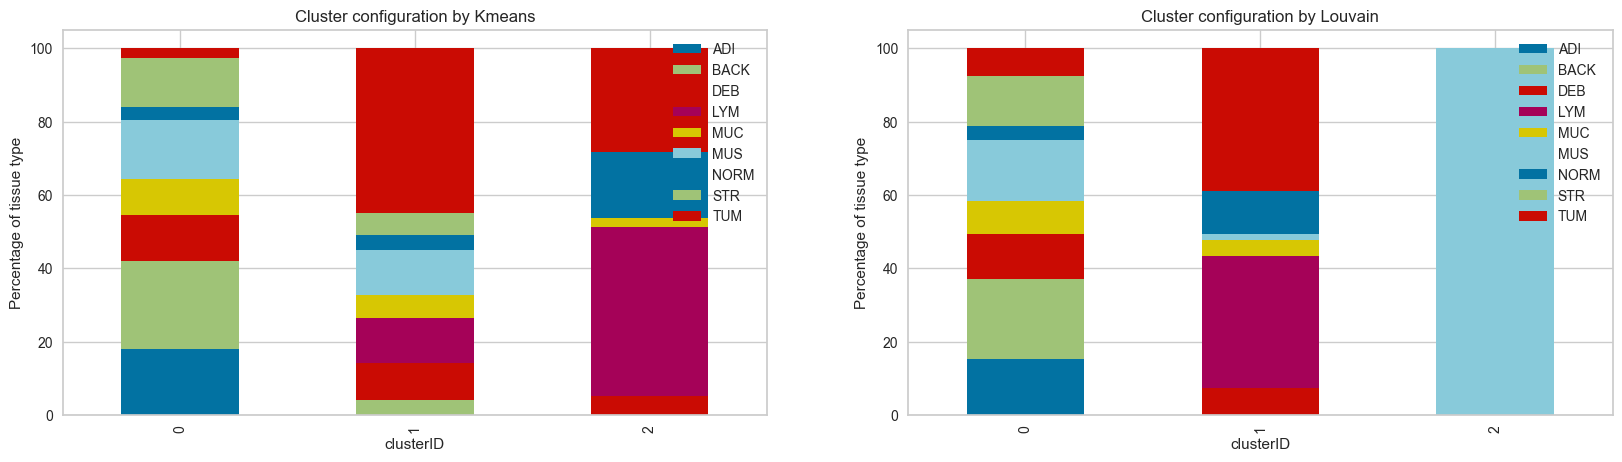

In [191]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans')

resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Louvain')
f.show()

# Preparing the dataset for PathologyGAN (PGE) and ResNet50



In [192]:
#PCA feature from 2 feature sets: pge_latent, resnet50_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]

#UMAP feature from 2 feature sets: pge_latent, resnet50_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]

#PGE test data
test_data_pge_pca = pge_pca_feature
test_data_pge_umap = pge_umap_feature

#PGE labels
filename_pge  = np.squeeze(pge_content['file_name'])
filename_pge = np.array([str(x) for x in filename_pge])
labels_pge = np.array([x.split('/')[2] for x in filename_pge])

#Resnet50 test data
test_data_resnet50_pca = resnet50_pca_feature
test_data_resnet50_umap = resnet50_umap_feature

#Resnet50 labels
filename_resnet50 = np.squeeze(resnet50_content['file_name'])
filename_resnet50 = np.array([str(x) for x in filename_resnet50])
labels_resnet50 = np.array([x.split('/')[2] for x in filename_resnet50])

# K-Means Clustering

Training the model using N=2...30 to find the optimal number of cluster using the Elbow method.

In [193]:
from sklearn.cluster import KMeans
from sknetwork.clustering import get_modularity
import networkx as nx
import community

In [194]:
seed = 2023
num_clusters = 30

In [195]:
def train_squared(test_data, Model=KMeans, **param):
  model_list = []

  if Model is KMeans:
    K = list(range(2, param['n_clusters']))
    for k in K:
      # print(f"KMeans at k = {k}")
      model = Model(n_clusters=k, n_init=10, random_state=seed)
      model_list.append(model.fit(test_data))

  elif Model is AgglomerativeClustering:
    # print(param)
    
    K = list(range(2, param['n_clusters']))
    for k in K:
      # print(f"Hierachical Clustering at k = {k}")
      model = Model(n_clusters=k, metric=param['affinity'], linkage=param['linkage'])
      model_list.append(model.fit_predict(test_data))
    # print(sum_list)      
    
  # TODO
  # elif Model is Louvain:
  #   K = np.arange(0.9, 1.1, 0.01)
  #   for r in K:
  #     # print(r)
  #     louvain_model = Louvain(resolution = r)
  #     adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
  #     louvain_assignment = louvain_model.fit_predict(adjacency_matrix)
  #     louvain_counts = np.unique(louvain_assignment, return_counts = True)
  #     # modularity_score = louvain_model
  #     modularity_score = get_modularity(adjacency_matrix, louvain_assignment)
  #     param['louvain_count_list'].extend([r,len(louvain_counts[0])])
  #     ##append score of louvain
  #     sum_list.append([r,modularity_score])

  return model_list



KMeans PGE ResNet

In [196]:
km_model_pge_pca = train_squared(test_data_pge_pca, n_clusters=num_clusters)
km_model_pge_umap = train_squared(test_data_pge_umap, n_clusters=num_clusters)

km_model_resnet_pca = train_squared(test_data_resnet50_pca, n_clusters=num_clusters)
km_model_resnet_umap = train_squared(test_data_resnet50_umap, n_clusters=num_clusters)

Hierachical PGE Resnet

In [197]:
hier_model_pge_pca = train_squared(test_data_pge_pca, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
hier_model_pge_umap = train_squared(test_data_pge_umap, Model=AgglomerativeClustering,  n_clusters=num_clusters, affinity="euclidean", linkage="single")

hier_model_resnet_pca = train_squared(test_data_resnet50_pca, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
hier_model_resnet_umap = train_squared(test_data_resnet50_umap, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")

Louvain PGE Resnet

In [198]:
# TODO
louvain_model_pge_pca = train_squared(test_data_pge_pca, Model=Louvain, n_clusters=num_clusters)
louvain_model_pge_umap = train_squared(test_data_pge_umap, Model=Louvain,  n_clusters=num_clusters)

louvain_model_resnet_pca = train_squared(test_data_resnet50_pca, Model=Louvain, n_clusters=num_clusters)
louvain_model_resnet_umap = train_squared(test_data_resnet50_umap, Model=Louvain, n_clusters=num_clusters)

In [199]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

def visual_louvain(test_data, resolution):
    # Apply PCA to reduce dimensionality to 3
    pca = PCA(n_components=3)
    test_data_pca = pca.fit_transform(test_data)

    # Compute distances in the reduced space
    distances = euclidean_distances(test_data_pca)
    adjacency_matrix = np.exp(-distances)

    # Apply Spectral Clustering
    n_neighbors = min(10, len(test_data_pca) - 1)
    spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=n_neighbors, random_state=42)
    labels = spectral.fit_predict(adjacency_matrix)

    # Create a graph
    G = nx.Graph()
    for i in range(len(test_data_pca)):
        G.add_node(i, pos=(test_data_pca[i, 0], test_data_pca[i, 1]))

    for i in range(len(test_data_pca)):
        for j in range(i + 1, len(test_data_pca)):
            G.add_edge(i, j, weight=adjacency_matrix[i, j])

    # Get node positions (considering only the first two dimensions for 2D visualization)
    pos = {k: v[:2] for k, v in nx.get_node_attributes(G, 'pos').items()}

    # Draw the 2D graph
    nx.draw(G, pos, with_labels=False , font_weight='bold', node_color=labels, cmap=plt.cm.RdYlBu, node_size=100)

    plt.show()

/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_spectral.py:688: UserWarning:

The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.

/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



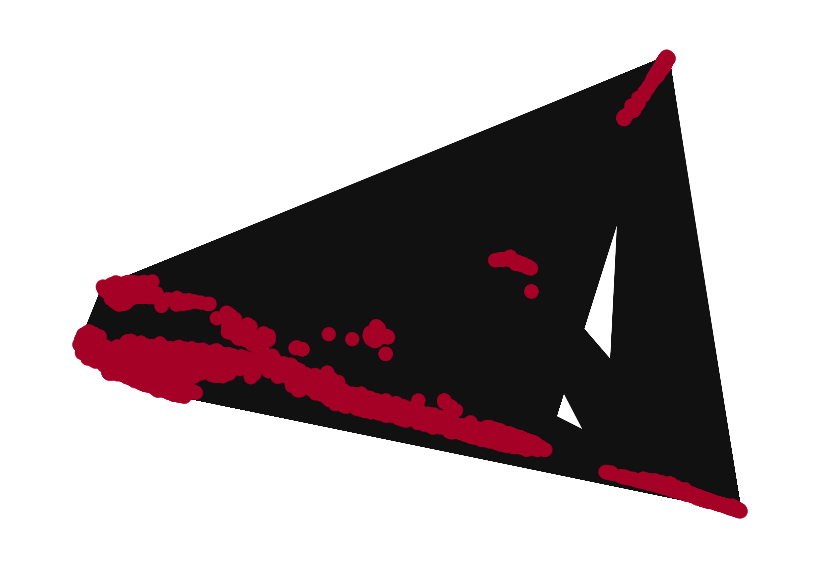

In [200]:
visual_louvain(test_data_pge_umap,0.97)

## Evaluation and Visualizing

We can observe from the above graphs that it is difficult to derive the exact k value using only the Elbow method from the curve. Hence, to get a better measurement, we are also calculating the silhouette score and v-measure to obtain the best k-value for both the feature sets.

Assuming the ground truth labels are not present, we are finding the 'k' using sillhouete score to find which 'k' perfectly fits the data.

### Intrinsic Measures

In [201]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

def get_best_kmean(data_for_clustering):
    # create data matrix
    data_matrix = np.matrix(data_for_clustering).astype(float)
    # scale the data
    mms = MinMaxScaler()
    scaled_data = mms.fit_transform(np.asarray(data_matrix))

    # choose k range
    k_range=range(2,20)
    # compute adjusted intertia
    best_k, results = chooseBestKforKMeans(scaled_data, k_range)
    # plot the results
    print('Best k',best_k)
    plt.figure(figsize=(7,4))
    plt.plot(results,'o')
    plt.title('Adjusted Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Adjusted Inertia')
    plt.xticks(range(2,20,1))
    return best_k

In [202]:
def get_best(score_list):
    k = [i[0] for i in score_list]
    value = [i[1] for i in score_list]
    return k[value.index(max(value))]


After using an equation to automatical determine the most suitable number of cluster for KMeans clustering algorithm its seems to be a conflict between manual and automate of PCA test data ones, while we our best k is exactly the same to automate ones of UMAP but PCA. In other word, we agreed that PCA data relationships can't be distinguish by KMeans clustering algorithm. Nevertheless, we considered to keep going with our manual consideration for best k cluster number.

#### Silhouette Coefficient

In [203]:
from yellowbrick.cluster import KElbowVisualizer

In [209]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import rand_score
from sklearn.metrics import v_measure_score

def evaluate_model(models, test_data, is_pge=True, m='kmean'):
    scores = []
    param = 2 ## TODO
    for model in models:
        # Example scoring criteria, you can add more as needed
        if m == 'kmean':
            model_fitted = model.predict(test_data)
        else:
            model_fitted = model
        silhouette = silhouette_score(test_data, model_fitted)
        davies_bouldin = davies_bouldin_score(test_data, model_fitted)
        if is_pge:
            rand_index = rand_score(labels_pge, model_fitted)
            v_measure = v_measure_score(labels_pge, model_fitted)
        else:
            rand_index = rand_score(labels_resnet50, model_fitted)
            v_measure = v_measure_score(labels_resnet50, model_fitted)
        

        scores.append({
            'param': param,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'rand_index': rand_index,
            'v_measure': v_measure
        })
        param += 1

    return scores
    

In [217]:
def elbow_visualization(test_data,Model=KMeans, **param):
    #keman
    if Model is KMeans:
        visualizer = KElbowVisualizer(Model(n_init=10, random_state=seed), k=(2, param['n_clusters']))
    elif Model is AgglomerativeClustering:
        visualizer = KElbowVisualizer(Model(metric=param['affinity'], linkage=param['linkage']), k=(2, param['n_clusters']))

    if visualizer:
        visualizer.fit(test_data)
        visualizer.show()
        optimal_k = visualizer.elbow_value_
        k_values = visualizer.k_values_
        k_scores = visualizer.k_scores_
        sum_list = list(zip(k_values, k_scores))
        return (optimal_k, sum_list)

In [206]:
def scores_visualizer(scores_df):
    # Data
    params = scores_df['param']
    silhouette_scores = scores_df['silhouette']
    davies_bouldin_scores = scores_df['davies_bouldin']
    rand_index_scores = scores_df['rand_index']
    v_measure_scores = scores_df['v_measure']

    # Find optimal k for each score
    best_k_silhouette = scores_df.loc[scores_df['silhouette'].idxmax()]['param']
    best_k_davies_bouldin = scores_df.loc[scores_df['davies_bouldin'].idxmin()]['param']
    best_k_rand_index = scores_df.loc[scores_df['rand_index'].idxmax()]['param']
    best_k_v_measure = scores_df.loc[scores_df['v_measure'].idxmax()]['param']

    # Visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(params, silhouette_scores, marker='o')
    plt.axvline(x=best_k_silhouette, color='r', linestyle='--', label=f'Optimal K: {best_k_silhouette}')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(params, davies_bouldin_scores, marker='o')
    plt.axvline(x=best_k_davies_bouldin, color='r', linestyle='--', label=f'Optimal K: {best_k_davies_bouldin}')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(params, rand_index_scores, marker='o')
    plt.axvline(x=best_k_rand_index, color='r', linestyle='--', label=f'Optimal K: {best_k_rand_index}')
    plt.title('Rand Index Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Rand Index Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(params, v_measure_scores, marker='o')
    plt.axvline(x=best_k_v_measure, color='r', linestyle='--', label=f'Optimal K: {best_k_v_measure}')
    plt.title('V-Measure Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('V-Measure Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


KMeans PGE

In [210]:
scores = evaluate_model(km_model_pge_pca, test_data_pge_pca)
scores_df_km_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(km_model_pge_umap, test_data_pge_umap)
scores_df_km_pge_umap = pd.DataFrame(scores)


KMeans Resnet

In [211]:
scores = evaluate_model(km_model_resnet_pca, test_data_resnet50_pca)
scores_df_km_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(km_model_resnet_umap, test_data_resnet50_umap)
scores_df_km_resnet_umap = pd.DataFrame(scores)


Hierachical PGE

In [213]:
scores = evaluate_model(hier_model_pge_pca, test_data_pge_pca, m='agglomerative')
scores_df_hier_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(hier_model_pge_umap, test_data_pge_umap, m='agglomerative')
scores_df_hier_pge_umap = pd.DataFrame(scores)


Hierachical Resnet

In [214]:
scores = evaluate_model(hier_model_resnet_pca, test_data_resnet50_pca, m='agglomerative')
scores_df_hier_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(hier_model_resnet_umap, test_data_resnet50_umap, m='agglomerative')
scores_df_hier_resnet_umap = pd.DataFrame(scores)

Louvain PGE

In [ ]:
scores = evaluate_model(louvain_model_pge_pca, test_data_pge_pca)
scores_df_louvain_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(louvain_model_pge_umap, test_data_pge_umap)
scores_df_louvain_pge_umap = pd.DataFrame(scores)

Louvain Resnet

In [ ]:
scores = evaluate_model(louvain_model_resnet_pca, test_data_resnet50_pca)
scores_df_louvain_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(louvain_model_resnet_umap, test_data_resnet50_umap)
scores_df_louvain_resnet_umap = pd.DataFrame(scores)

KMeans Evaluation

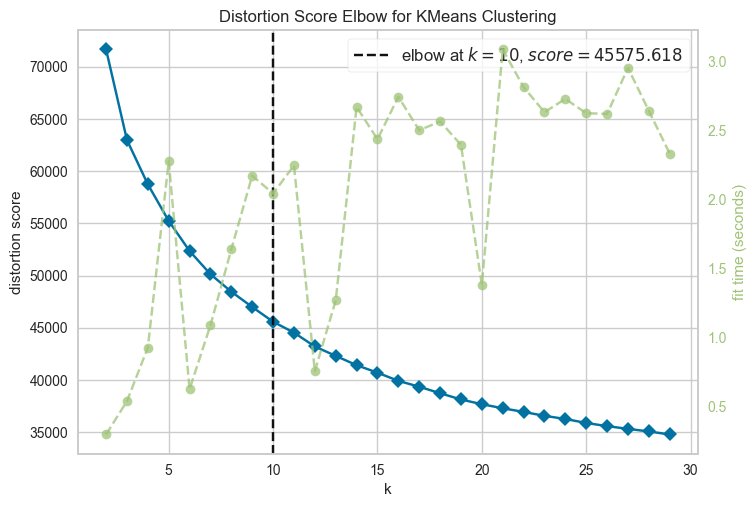

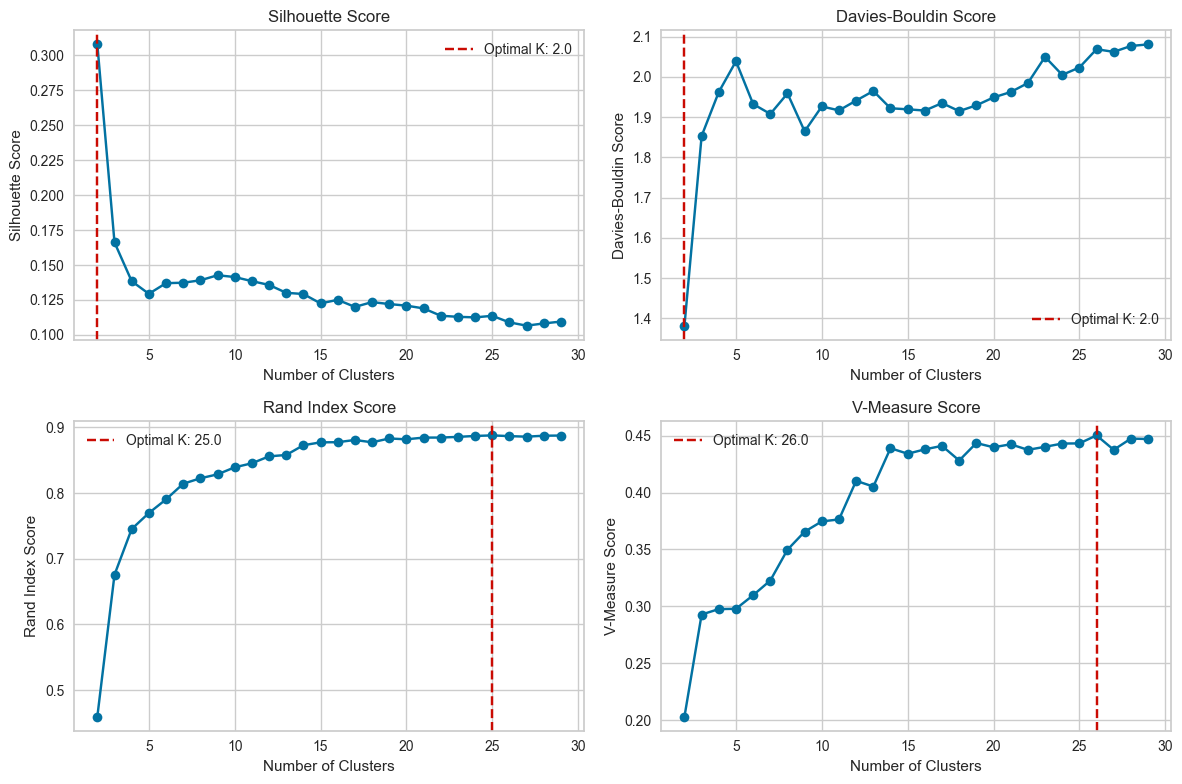

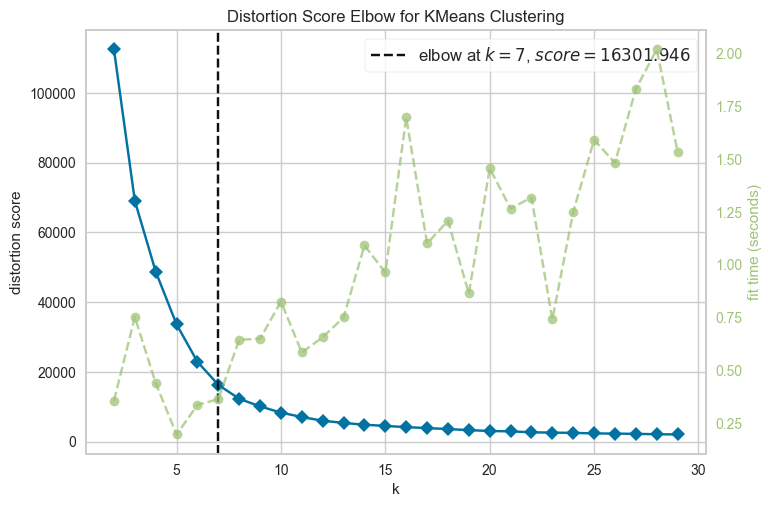

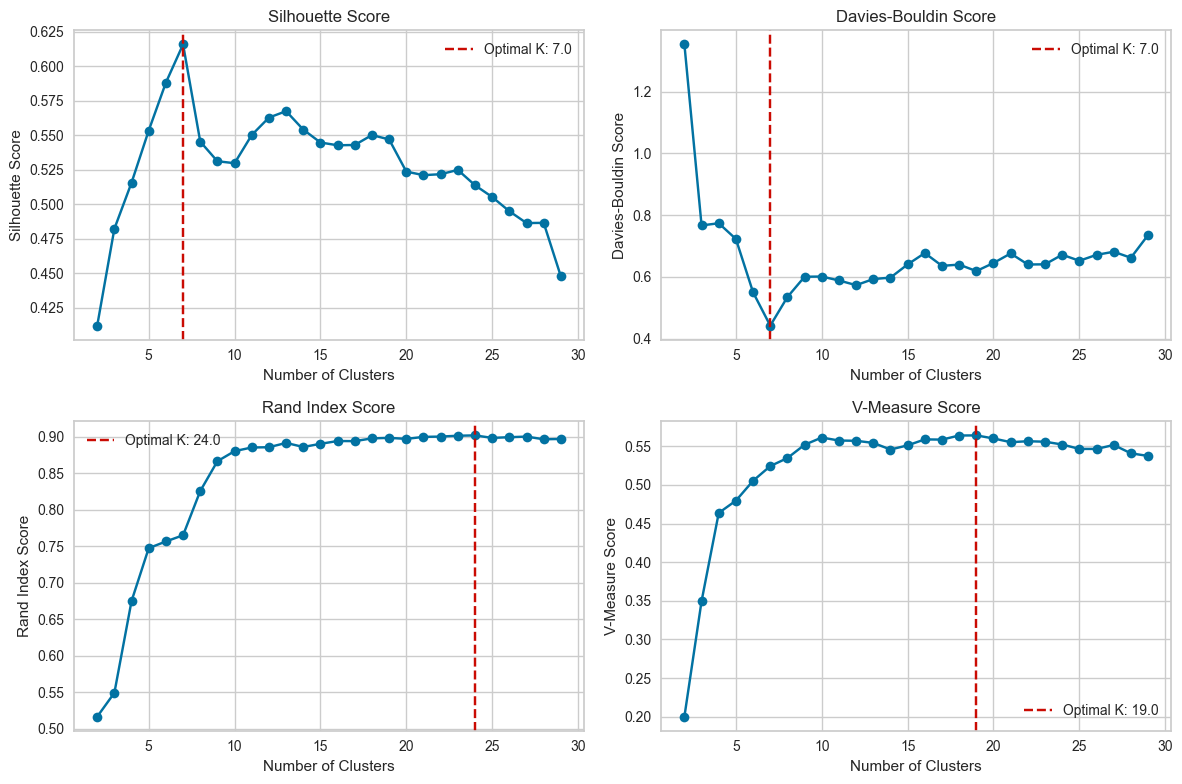

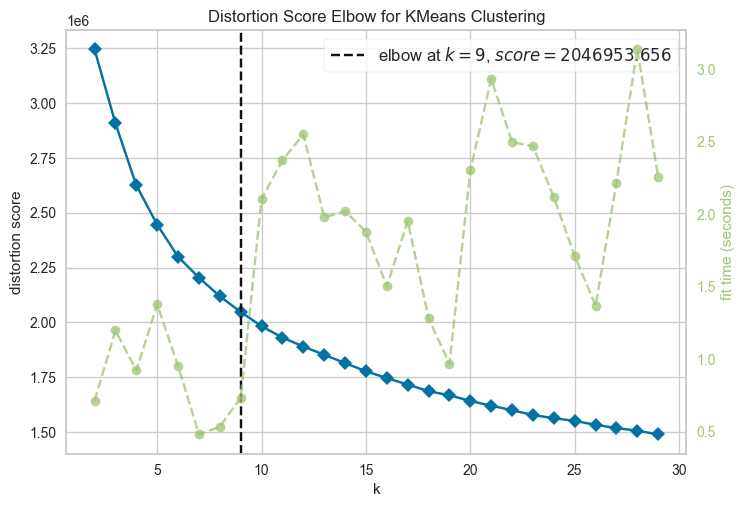

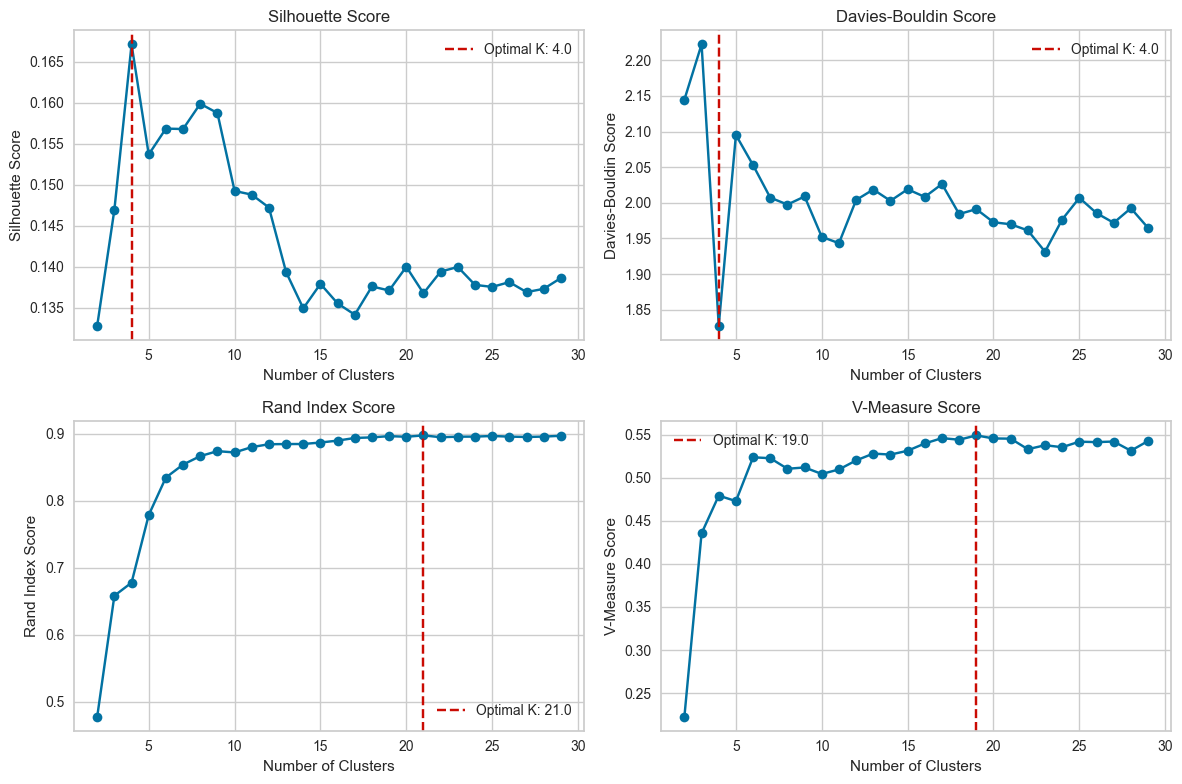

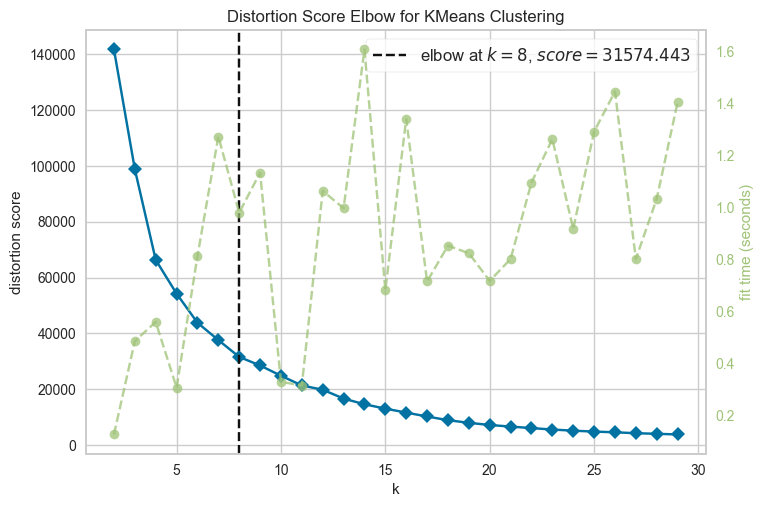

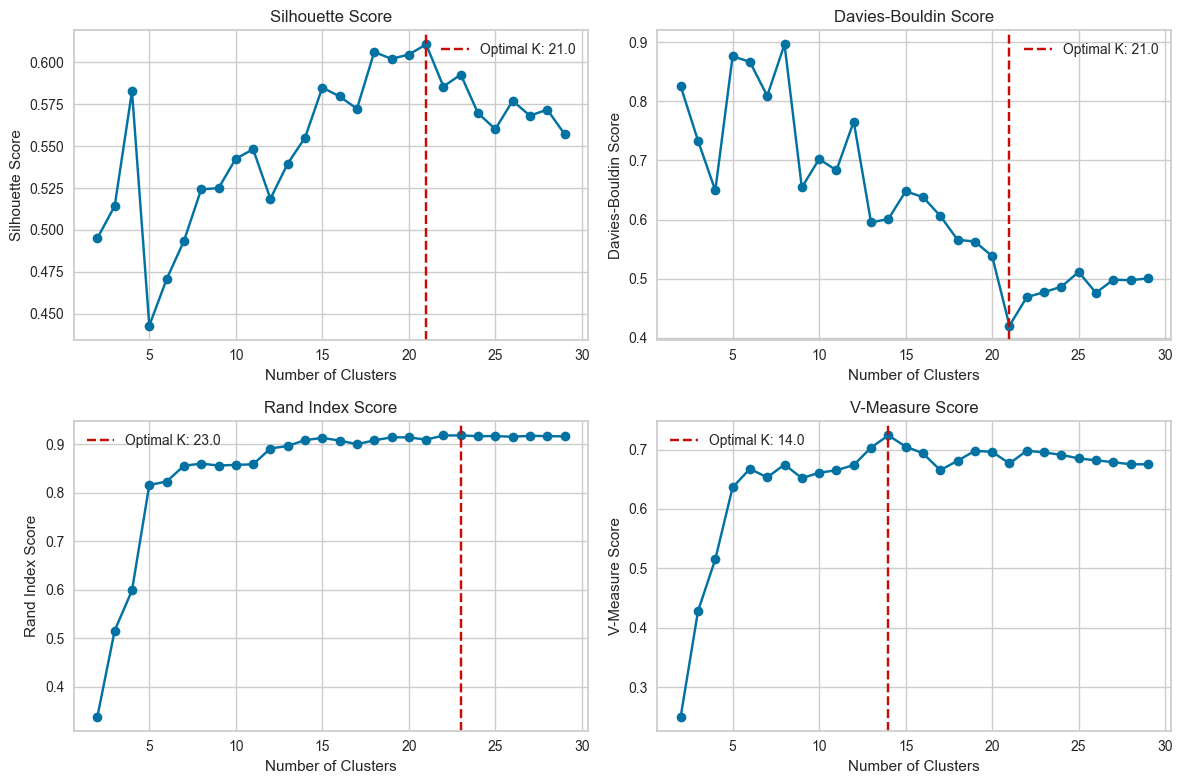

In [215]:
elbow_visualization(test_data=test_data_pge_pca,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_pge_pca)

elbow_visualization(test_data=test_data_pge_umap,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_pge_umap)

elbow_visualization(test_data=test_data_resnet50_pca,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_resnet_pca)

elbow_visualization(test_data=test_data_resnet50_umap,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_resnet_umap)


Hierachical Evaluation

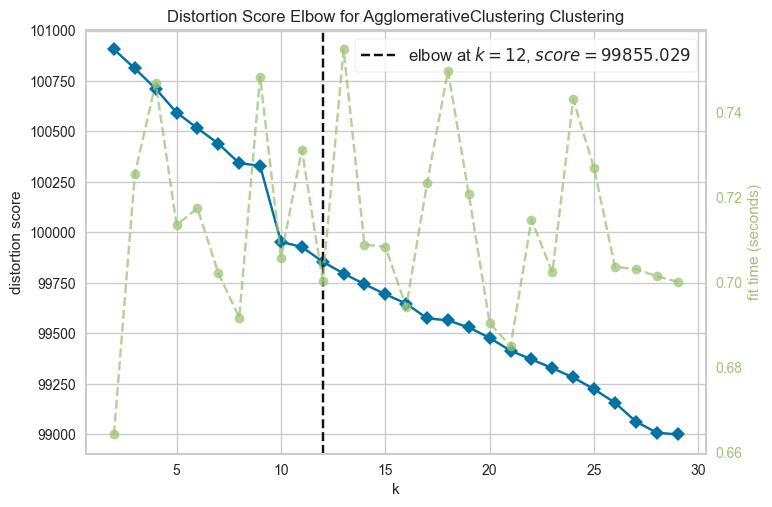

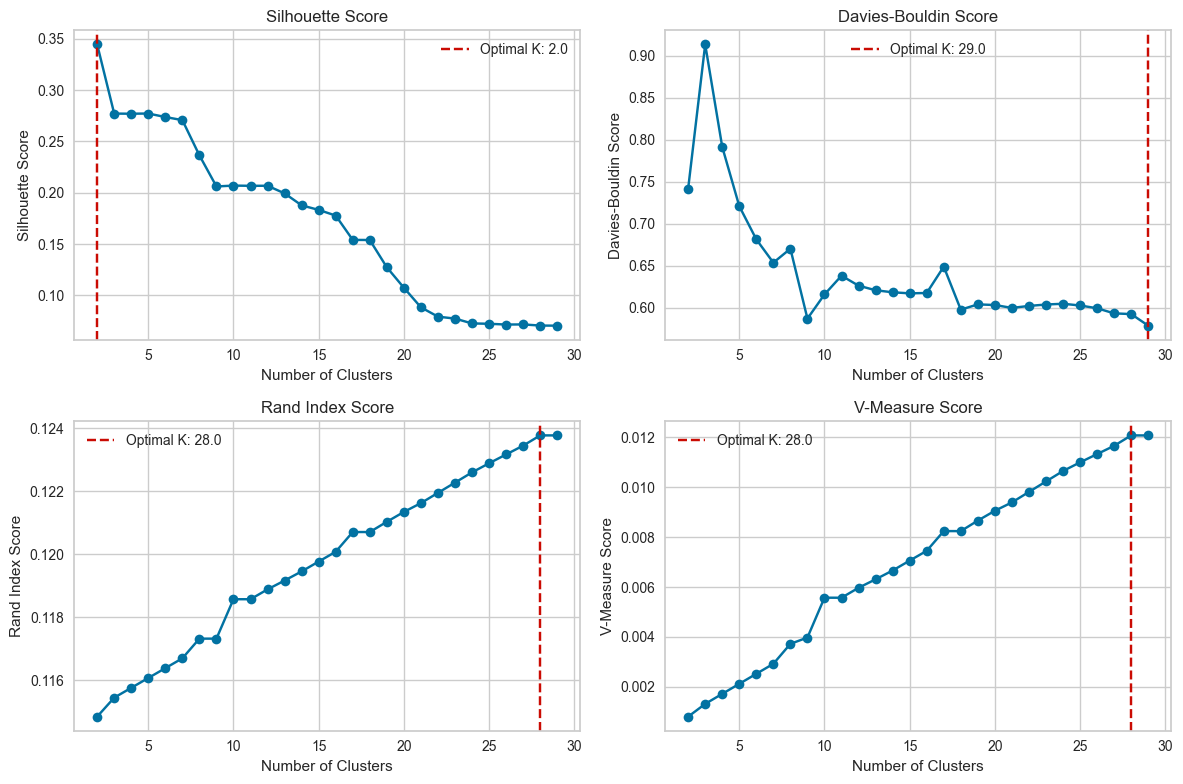

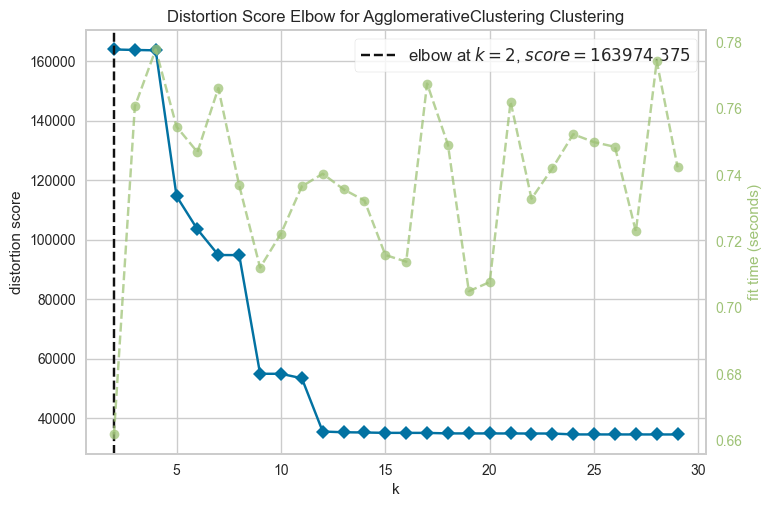

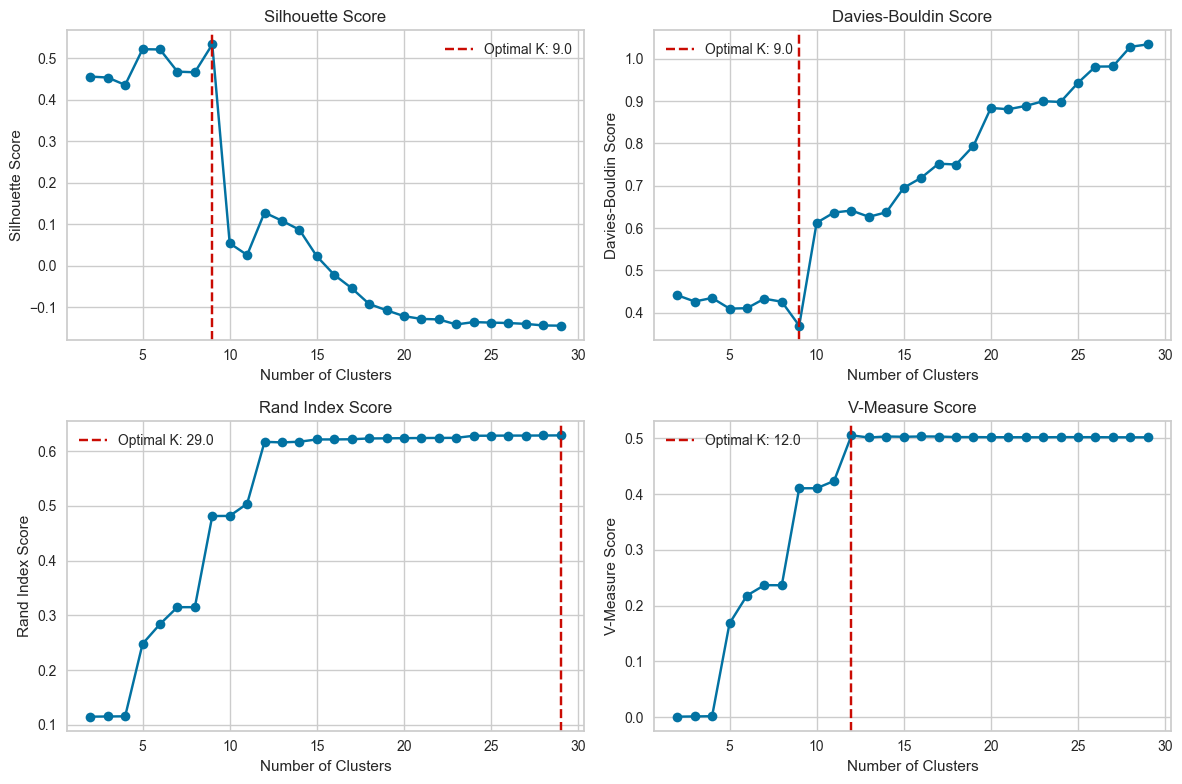

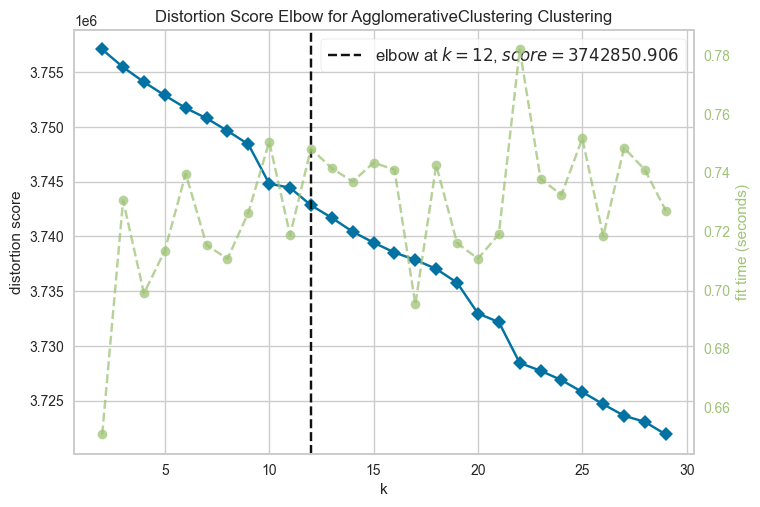

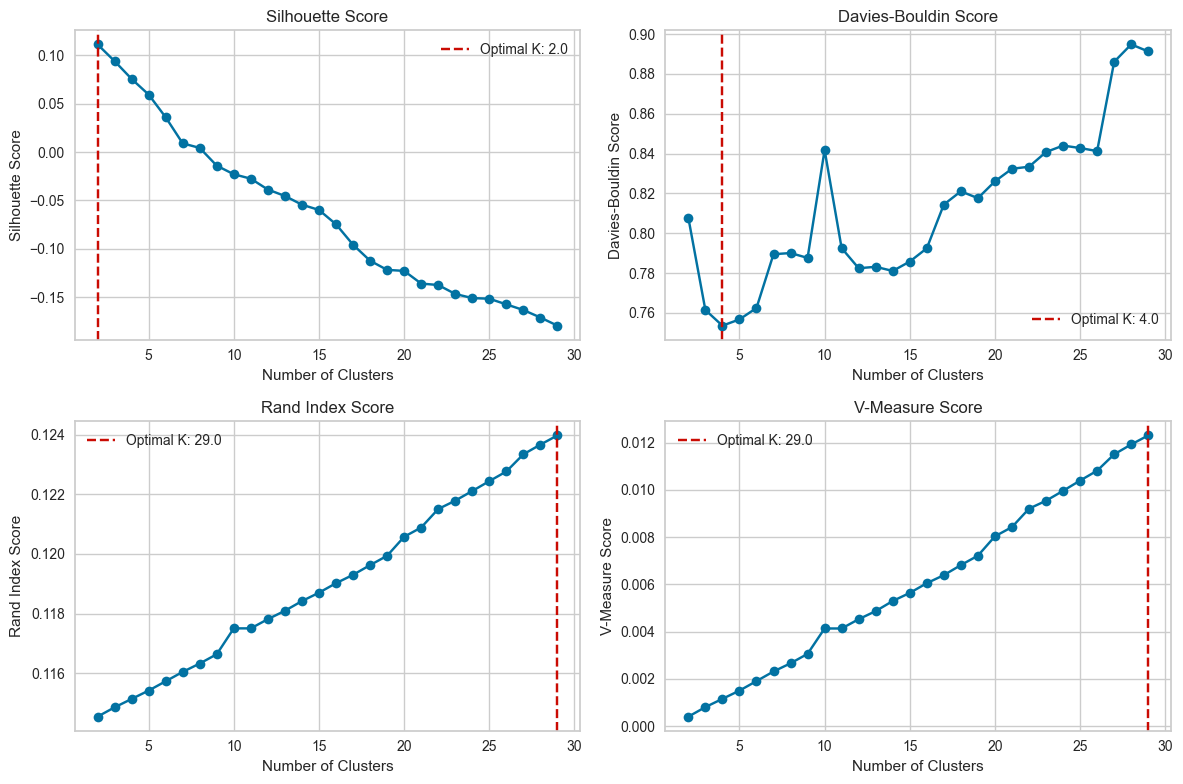

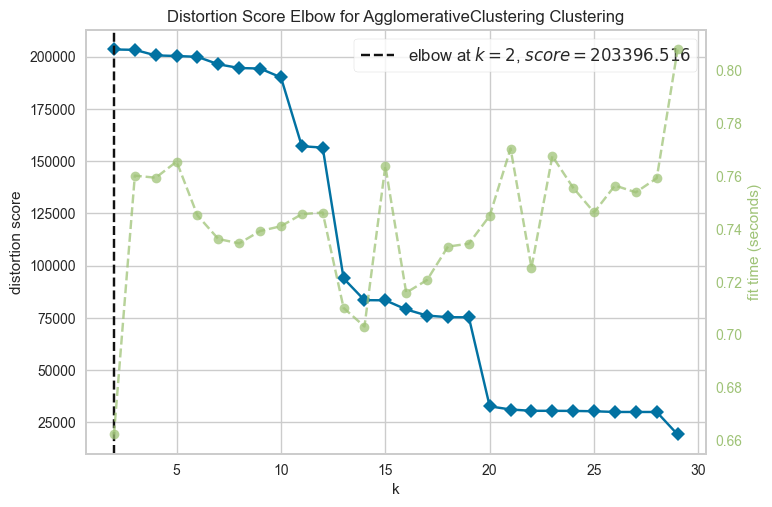

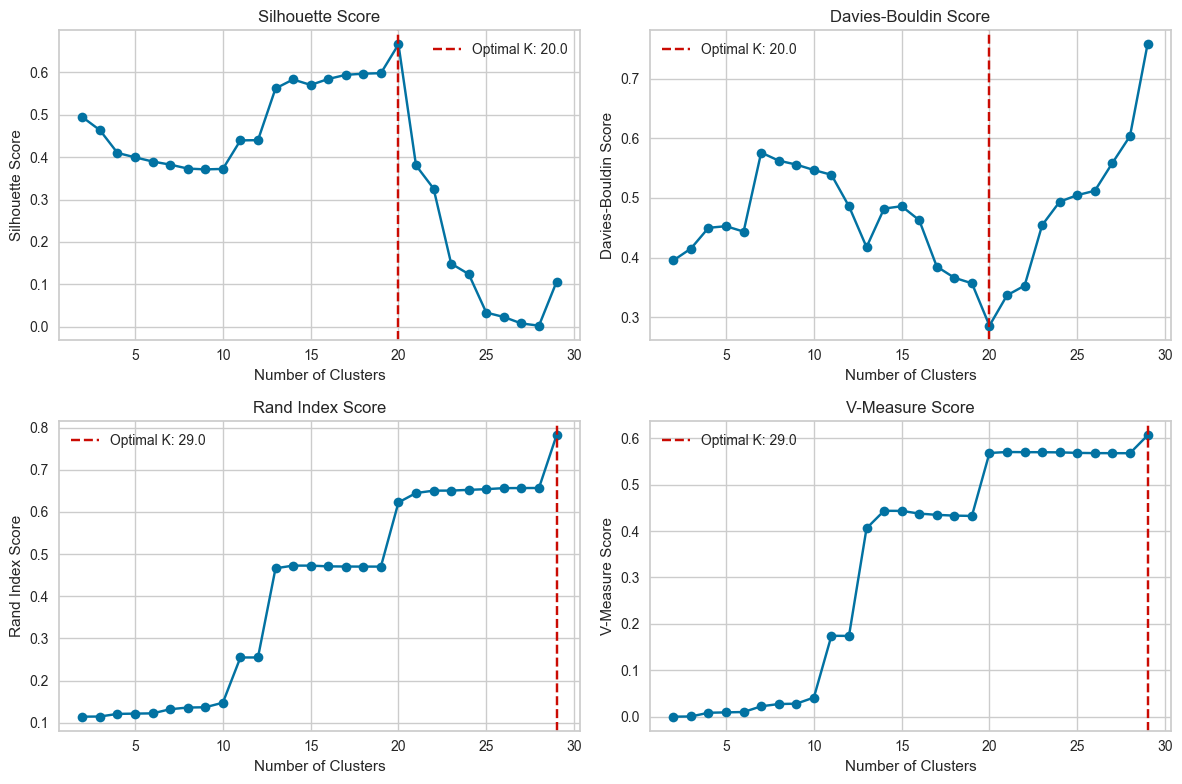

In [218]:
elbow_visualization(test_data=test_data_pge_pca,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_pge_pca)

elbow_visualization(test_data=test_data_pge_umap,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_pge_umap)

elbow_visualization(test_data=test_data_resnet50_pca,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_resnet_pca)

elbow_visualization(test_data=test_data_resnet50_umap,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_resnet_umap)

scores

In [ ]:
def cluster_visualization(k, test_data):
    # Using KMeans as an example clustering algorithm
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_assignments = kmeans.fit_predict(test_data)

    # Assuming your test_data is a 2D array, you can use it for plotting
    plt.scatter(test_data[:, 0], test_data[:, 1], c=cluster_assignments, cmap='viridis')
    plt.title(f'Cluster Visualization (k={k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


## May not use

In [ ]:
# PGE
silhouette_scores_pca_pge_kmeans = evaluate_model( , test_data_pge_pca)
silhouette_scores_pca_pge_hier = evaluate_model('silhouette', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
silhouette_scores_pca_pge_louvain = evaluate_model('silhouette', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

silhouette_scores_umap_pge_kmeans = evaluate_model('silhouette', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
silhouette_scores_umap_pge_hier = evaluate_model('silhouette', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
silhouette_scores_umap_pge_louvain = evaluate_model('silhouette', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
silhouette_scores_pca_resnet_kmeans = evaluate_model('silhouette', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
silhouette_scores_pca_resnet_hier = evaluate_model('silhouette', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
silhouette_scores_pca_resnet_louvain = evaluate_model('silhouette', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

silhouette_scores_umap_resnet_kmeans = evaluate_model('silhouette', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
silhouette_scores_umap_resnet_hier = evaluate_model('silhouette', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
silhouette_scores_umap_resnet_louvain = evaluate_model('silhouette', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [ ]:
# PGE DataFrame
pge_silhouette_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Silhouette': [silhouette_scores_pca_pge_kmeans, silhouette_scores_pca_pge_hier, silhouette_scores_pca_pge_louvain],
    'UMAP_Silhouette': [silhouette_scores_umap_pge_kmeans, silhouette_scores_umap_pge_hier, silhouette_scores_umap_pge_louvain],
}

pge_silhouette_df = pd.DataFrame(pge_silhouette_data)

# ResNet50 DataFrame
resnet_silhouette_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Silhouette': [silhouette_scores_pca_resnet_kmeans, silhouette_scores_pca_resnet_hier, silhouette_scores_pca_resnet_louvain],
    'UMAP_Silhouette': [silhouette_scores_umap_resnet_kmeans, silhouette_scores_umap_resnet_hier, silhouette_scores_umap_resnet_louvain],
}

resnet_silhouette_df = pd.DataFrame(resnet_silhouette_data)

# Concatenate the DataFrames
result_silhouette_df = pd.concat([pge_silhouette_df, resnet_silhouette_df], keys=['PGE', 'ResNet50'], axis=1)

# Display the DataFrame
result_silhouette_df

PGE                                      ResNet50                 \
           Model PCA_Silhouette UMAP_Silhouette          Model PCA_Silhouette   
0         KMeans       0.130472        0.550007         KMeans       0.139767   
1  Agglomerative       0.344508        0.533373  Agglomerative       0.111404   
2        Louvain       0.091899        0.492781        Louvain       0.014929   

                   
  UMAP_Silhouette  
0        0.554215  
1        0.666218  
2        0.372998

In [ ]:
print("Silhouette Scores for PCA on PGE with KMeans:", silhouette_scores_pca_pge_kmeans)
print("Silhouette Scores for PCA on PGE with Hierarchical:", silhouette_scores_pca_pge_hier)
print("Silhouette Scores for PCA on PGE with Louvain:", silhouette_scores_pca_pge_louvain)

print("Silhouette Scores for UMAP on PGE with KMeans:", silhouette_scores_umap_pge_kmeans)
print("Silhouette Scores for UMAP on PGE with Hierarchical:", silhouette_scores_umap_pge_hier)
print("Silhouette Scores for UMAP on PGE with Louvain:", silhouette_scores_umap_pge_louvain)

print("Silhouette Scores for PCA on ResNet50 with KMeans:", silhouette_scores_pca_resnet_kmeans)
print("Silhouette Scores for PCA on ResNet50 with Hierarchical:", silhouette_scores_pca_resnet_hier)
print("Silhouette Scores for PCA on ResNet50 with Louvain:", silhouette_scores_pca_resnet_louvain)

print("Silhouette Scores for UMAP on ResNet50 with KMeans:", silhouette_scores_umap_resnet_kmeans)
print("Silhouette Scores for UMAP on ResNet50 with Hierarchical:", silhouette_scores_umap_resnet_hier)
print("Silhouette Scores for UMAP on ResNet50 with Louvain:", silhouette_scores_umap_resnet_louvain)

Silhouette Scores for PCA on PGE with KMeans: 0.12573685
Silhouette Scores for PCA on PGE with Hierarchical: 0.34450808
Silhouette Scores for PCA on PGE with Louvain: 0.09189911
Silhouette Scores for UMAP on PGE with KMeans: 0.550109
Silhouette Scores for UMAP on PGE with Hierarchical: 0.5333726
Silhouette Scores for UMAP on PGE with Louvain: 0.49278057
Silhouette Scores for PCA on ResNet50 with KMeans: 0.14244966
Silhouette Scores for PCA on ResNet50 with Hierarchical: 0.111403994
Silhouette Scores for PCA on ResNet50 with Louvain: 0.014929112
Silhouette Scores for UMAP on ResNet50 with KMeans: 0.518395
Silhouette Scores for UMAP on ResNet50 with Hierarchical: 0.6662179
Silhouette Scores for UMAP on ResNet50 with Louvain: 0.37299815


#### Devies-Bouldin Index

In [ ]:
# PGE
davies_scores_pca_pge_kmeans = evaluate_model('davies', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
davies_scores_pca_pge_hier = evaluate_model('davies', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
davies_scores_pca_pge_louvain = evaluate_model('davies', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

davies_scores_umap_pge_kmeans = evaluate_model('davies', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
davies_scores_umap_pge_hier = evaluate_model('davies', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
davies_scores_umap_pge_louvain = evaluate_model('davies', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
davies_scores_pca_resnet_kmeans = evaluate_model('davies', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
davies_scores_pca_resnet_hier = evaluate_model('davies', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
davies_scores_pca_resnet_louvain = evaluate_model('davies', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

davies_scores_umap_resnet_kmeans = evaluate_model('davies', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
davies_scores_umap_resnet_hier = evaluate_model('davies', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
davies_scores_umap_resnet_louvain = evaluate_model('davies', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [ ]:
# PGE DataFrame
davies_silhouette_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Davies': [davies_scores_pca_pge_kmeans, davies_scores_pca_pge_hier, davies_scores_pca_pge_louvain],
    'UMAP_Davies': [davies_scores_umap_pge_kmeans, davies_scores_umap_pge_hier, davies_scores_umap_pge_louvain],
}

davies_silhouette_df = pd.DataFrame(davies_silhouette_data)

# ResNet50 DataFrame
resnet_davies_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Davies': [davies_scores_pca_resnet_kmeans, davies_scores_pca_resnet_hier, davies_scores_pca_resnet_louvain],
    'UMAP_Davies': [davies_scores_umap_resnet_kmeans, davies_scores_umap_resnet_hier, davies_scores_umap_resnet_louvain],
}

resnet_davies_df = pd.DataFrame(resnet_davies_data)

# Concatenate the DataFrames
result_davies_df = pd.concat([davies_silhouette_df, resnet_davies_df], keys=['PGE', 'ResNet50'], axis=1)

# Display the DataFrame
result_davies_df


PGE                              ResNet50                       
           Model PCA_Davies UMAP_Davies          Model PCA_Davies UMAP_Davies
0         KMeans   1.936968    0.589666         KMeans   1.973707    0.763566
1  Agglomerative   0.741708    0.369592  Agglomerative   0.807793    0.285907
2        Louvain   1.935036    0.710068        Louvain   2.401860    0.830580

In [ ]:
print("Davies Scores for PCA on PGE with KMeans:", davies_scores_pca_pge_kmeans)
print("Davies Scores for PCA on PGE with Hierarchical:", davies_scores_pca_pge_hier)
print("Davies Scores for PCA on PGE with Louvain:", davies_scores_pca_pge_louvain)

print("Davies Scores for UMAP on PGE with KMeans:", davies_scores_umap_pge_kmeans)
print("Davies Scores for UMAP on PGE with Hierarchical:", davies_scores_umap_pge_hier)
print("Davies Scores for UMAP on PGE with Louvain:", davies_scores_umap_pge_louvain)

print("Davies Scores for PCA on ResNet50 with KMeans:", davies_scores_pca_resnet_kmeans)
print("Davies Scores for PCA on ResNet50 with Hierarchical:", davies_scores_pca_resnet_hier)
print("Davies Scores for PCA on ResNet50 with Louvain:", davies_scores_pca_resnet_louvain)

print("Davies Scores for UMAP on ResNet50 with KMeans:", davies_scores_umap_resnet_kmeans)
print("Davies Scores for UMAP on ResNet50 with Hierarchical:", davies_scores_umap_resnet_hier)
print("Davies Scores for UMAP on ResNet50 with Louvain:", davies_scores_umap_resnet_louvain)


Davies Scores for PCA on PGE with KMeans: 1.9272204646344664
Davies Scores for PCA on PGE with Hierarchical: 0.7417079047182548
Davies Scores for PCA on PGE with Louvain: 1.935035512835478
Davies Scores for UMAP on PGE with KMeans: 0.5895546110025731
Davies Scores for UMAP on PGE with Hierarchical: 0.36959168927130875
Davies Scores for UMAP on PGE with Louvain: 0.7100678006876513
Davies Scores for PCA on ResNet50 with KMeans: 1.9760523147057667
Davies Scores for PCA on ResNet50 with Hierarchical: 0.8077925909242978
Davies Scores for PCA on ResNet50 with Louvain: 2.401859511763125
Davies Scores for UMAP on ResNet50 with KMeans: 0.7083434173803232
Davies Scores for UMAP on ResNet50 with Hierarchical: 0.28590703874579926
Davies Scores for UMAP on ResNet50 with Louvain: 0.8305795184667881


### Extrinsic Measures

#### Rand Index

In [ ]:
# PGE
rand_scores_pca_pge_kmeans = evaluate_model('rand_pge', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
rand_scores_pca_pge_hier = evaluate_model('rand_pge', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
rand_scores_pca_pge_louvain = evaluate_model('rand_pge', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

rand_scores_umap_pge_kmeans = evaluate_model('rand_pge', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
rand_scores_umap_pge_hier = evaluate_model('rand_pge', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
rand_scores_umap_pge_louvain = evaluate_model('rand_pge', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
rand_scores_pca_resnet_kmeans = evaluate_model('rand_resnet', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
rand_scores_pca_resnet_hier = evaluate_model('rand_resnet', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
rand_scores_pca_resnet_louvain = evaluate_model('rand_resnet', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

rand_scores_umap_resnet_kmeans = evaluate_model('rand_resnet', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
rand_scores_umap_resnet_hier = evaluate_model('rand_resnet', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
rand_scores_umap_resnet_louvain = evaluate_model('rand_resnet', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [ ]:
# PGE DataFrame
rand_index_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Rand_Index': [rand_scores_pca_pge_kmeans, rand_scores_pca_pge_hier, rand_scores_pca_pge_louvain],
    'UMAP_Rand_Index': [rand_scores_umap_pge_kmeans, rand_scores_umap_pge_hier, rand_scores_umap_pge_louvain],
}

rand_index_df = pd.DataFrame(rand_index_data)

# ResNet50 DataFrame
resnet_rand_index_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_Rand_Index': [rand_scores_pca_resnet_kmeans, rand_scores_pca_resnet_hier, rand_scores_pca_resnet_louvain],
    'UMAP_Rand_Index': [rand_scores_umap_resnet_kmeans, rand_scores_umap_resnet_hier, rand_scores_umap_resnet_louvain],
}

resnet_rand_index_df = pd.DataFrame(resnet_rand_index_data)

# Concatenate the DataFrames
result_rand_index_df = pd.concat([rand_index_df, resnet_rand_index_df], keys=['PGE', 'ResNet50'], axis=1)

# Display the DataFrame
result_rand_index_df


PGE                                      ResNet50                 \
           Model PCA_Rand_Index UMAP_Rand_Index          Model PCA_Rand_Index   
0         KMeans       0.872927        0.880417         KMeans       0.882608   
1  Agglomerative       0.114848        0.481231  Agglomerative       0.114536   
2        Louvain       0.642041        0.751419        Louvain       0.747479   

                   
  UMAP_Rand_Index  
0        0.871227  
1        0.622417  
2        0.809875

In [ ]:
# Print the Rand Index scores
print("Rand Index Scores for PCA on PGE with KMeans:", rand_scores_pca_pge_kmeans)
print("Rand Index Scores for PCA on PGE with Hierarchical:", rand_scores_pca_pge_hier)
print("Rand Index Scores for PCA on PGE with Louvain:", rand_scores_pca_pge_louvain)

print("Rand Index Scores for UMAP on PGE with KMeans:", rand_scores_umap_pge_kmeans)
print("Rand Index Scores for UMAP on PGE with Hierarchical:", rand_scores_umap_pge_hier)
print("Rand Index Scores for UMAP on PGE with Louvain:", rand_scores_umap_pge_louvain)

print("Rand Index Scores for PCA on ResNet50 with KMeans:", rand_scores_pca_resnet_kmeans)
print("Rand Index Scores for PCA on ResNet50 with Hierarchical:", rand_scores_pca_resnet_hier)
print("Rand Index Scores for PCA on ResNet50 with Louvain:", rand_scores_pca_resnet_louvain)

print("Rand Index Scores for UMAP on ResNet50 with KMeans:", rand_scores_umap_resnet_kmeans)
print("Rand Index Scores for UMAP on ResNet50 with Hierarchical:", rand_scores_umap_resnet_hier)
print("Rand Index Scores for UMAP on ResNet50 with Louvain:", rand_scores_umap_resnet_louvain)

Rand Index Scores for PCA on PGE with KMeans: 0.8725653130626125
Rand Index Scores for PCA on PGE with Hierarchical: 0.11484816963392679
Rand Index Scores for PCA on PGE with Louvain: 0.6420407281456292
Rand Index Scores for UMAP on PGE with KMeans: 0.8855946389277856
Rand Index Scores for UMAP on PGE with Hierarchical: 0.48123072614522905
Rand Index Scores for UMAP on PGE with Louvain: 0.7514190838167634
Rand Index Scores for PCA on ResNet50 with KMeans: 0.8821919583916783
Rand Index Scores for PCA on ResNet50 with Hierarchical: 0.11453618723744749
Rand Index Scores for PCA on ResNet50 with Louvain: 0.747479175835167
Rand Index Scores for UMAP on ResNet50 with KMeans: 0.8597047409481896
Rand Index Scores for UMAP on ResNet50 with Hierarchical: 0.6224168033606722
Rand Index Scores for UMAP on ResNet50 with Louvain: 0.8098748549709942


#### V-measure

In [ ]:
# PGE
v_measure_scores_pca_pge_kmeans = evaluate_model('v_measure_pge', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
v_measure_scores_pca_pge_hier = evaluate_model('v_measure_pge', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
v_measure_scores_pca_pge_louvain = evaluate_model('v_measure_pge', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

v_measure_scores_umap_pge_kmeans = evaluate_model('v_measure_pge', test_data_pge_umap,best_k_pge_umap_kmean,Model=AgglomerativeClustering)
v_measure_scores_umap_pge_hier = evaluate_model('v_measure_pge', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
v_measure_scores_umap_pge_louvain = evaluate_model('v_measure_pge', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
v_measure_scores_pca_resnet_kmeans = evaluate_model('v_measure_resnet', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
v_measure_scores_pca_resnet_hier = evaluate_model('v_measure_resnet', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
v_measure_scores_pca_resnet_louvain = evaluate_model('v_measure_resnet', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

v_measure_scores_umap_resnet_kmeans = evaluate_model('v_measure_resnet', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
v_measure_scores_umap_resnet_hier = evaluate_model('v_measure_resnet', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
v_measure_scores_umap_resnet_louvain = evaluate_model('v_measure_resnet', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)

In [ ]:
# PGE DataFrame
v_measure_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_V_Measure': [v_measure_scores_pca_pge_kmeans, v_measure_scores_pca_pge_hier, v_measure_scores_pca_pge_louvain],
    'UMAP_V_Measure': [v_measure_scores_umap_pge_kmeans, v_measure_scores_umap_pge_hier, v_measure_scores_umap_pge_louvain],
}

v_measure_df = pd.DataFrame(v_measure_data)

# ResNet50 DataFrame
resnet_v_measure_data = {
    'Model': ['KMeans', 'Agglomerative', 'Louvain'],
    'PCA_V_Measure': [v_measure_scores_pca_resnet_kmeans, v_measure_scores_pca_resnet_hier, v_measure_scores_pca_resnet_louvain],
    'UMAP_V_Measure': [v_measure_scores_umap_resnet_kmeans, v_measure_scores_umap_resnet_hier, v_measure_scores_umap_resnet_louvain],
}

resnet_v_measure_df = pd.DataFrame(resnet_v_measure_data)

# Concatenate the DataFrames
result_v_measure_df = pd.concat([v_measure_df, resnet_v_measure_df], keys=['PGE', 'ResNet50'], axis=1)

# Display the DataFrame
result_v_measure_df


PGE                                    ResNet50                \
           Model PCA_V_Measure UMAP_V_Measure          Model PCA_V_Measure   
0         KMeans      0.440257       0.423594         KMeans      0.529996   
1  Agglomerative      0.000807       0.410482  Agglomerative      0.000404   
2        Louvain      0.256304       0.431029        Louvain      0.354170   

                  
  UMAP_V_Measure  
0       0.654614  
1       0.568013  
2       0.580891

In [ ]:
# Print the V-Measure scores
print("V-Measure Scores for PCA on PGE with KMeans:", v_measure_scores_pca_pge_kmeans)
print("V-Measure Scores for PCA on PGE with Hierarchical:", v_measure_scores_pca_pge_hier)
print("V-Measure Scores for PCA on PGE with Louvain:", v_measure_scores_pca_pge_louvain)

print("V-Measure Scores for UMAP on PGE with KMeans:", v_measure_scores_umap_pge_kmeans)
print("V-Measure Scores for UMAP on PGE with Hierarchical:", v_measure_scores_umap_pge_hier)
print("V-Measure Scores for UMAP on PGE with Louvain:", v_measure_scores_umap_pge_louvain)

print("V-Measure Scores for PCA on ResNet50 with KMeans:", v_measure_scores_pca_resnet_kmeans)
print("V-Measure Scores for PCA on ResNet50 with Hierarchical:", v_measure_scores_pca_resnet_hier)
print("V-Measure Scores for PCA on ResNet50 with Louvain:", v_measure_scores_pca_resnet_louvain)

print("V-Measure Scores for UMAP on ResNet50 with KMeans:", v_measure_scores_umap_resnet_kmeans)
print("V-Measure Scores for UMAP on ResNet50 with Hierarchical:", v_measure_scores_umap_resnet_hier)
print("V-Measure Scores for UMAP on ResNet50 with Louvain:", v_measure_scores_umap_resnet_louvain)


V-Measure Scores for PCA on PGE with KMeans: 0.4291923231408508
V-Measure Scores for PCA on PGE with Hierarchical: 0.0008069260396096387
V-Measure Scores for PCA on PGE with Louvain: 0.25630358060693975
V-Measure Scores for UMAP on PGE with KMeans: 0.42359360244584604
V-Measure Scores for UMAP on PGE with Hierarchical: 0.4104823590518792
V-Measure Scores for UMAP on PGE with Louvain: 0.4310290908405775
V-Measure Scores for PCA on ResNet50 with KMeans: 0.5176007757496563
V-Measure Scores for PCA on ResNet50 with Hierarchical: 0.00040361549378110456
V-Measure Scores for PCA on ResNet50 with Louvain: 0.3541701616721559
V-Measure Scores for UMAP on ResNet50 with KMeans: 0.6633530486105343
V-Measure Scores for UMAP on ResNet50 with Hierarchical: 0.5680131180078676
V-Measure Scores for UMAP on ResNet50 with Louvain: 0.5808905749417033


# Cluster Visualization

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# v_label_umap_resnet_kmeans, v_measure_scores_umap_resnet_kmeans = evaluate_model('v_measure_resnet', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)


# km_labels = v_label_umap_resnet_kmeans

cluster_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for _ in range(100)]

def plot(test_data, k):

    # PCA
    pca_scaled_std = PCA(n_components=3, random_state=seed)
    X_pca_3d = pca_scaled_std.fit_transform(test_data)

    # Create a Plotly 3D Scatter plot
    traces = []
    for l, c in zip(range(0, k), cluster_colors[0:k]):
        trace = go.Scatter3d(
            x=X_pca_3d[k == l, 0],
            y=X_pca_3d[k == l, 1],
            z=X_pca_3d[k == l, 2],
            mode='markers',
            name=f'cluster {l}',
            marker=dict(size=4, opacity=0.8, color=c),
        )
        traces.append(trace)

    layout = go.Layout(
        title="3D PCA Visualization",
        scene=dict(
            xaxis=dict(title='Principal Component 1'),
            yaxis=dict(title='Principal Component 2'),
            zaxis=dict(title='Principal Component 3'),
        ),
    )

    fig = go.Figure(data=traces, layout=layout)

# Update layout for better interaction
# fig.update_layout(
#     updatemenus=[
#         dict(
#             type='buttons',
#             showactive=False,
#             buttons=[
#                 dict(label='Rotate X',
#                     method='relayout',
#                     args=['scene.camera.projection.rotation.x', 15]),
#                 dict(label='Rotate Y',
#                     method='relayout',
#                     args=['scene.camera.projection.rotation.y', 15]),
#                 dict(label='Rotate Z',
#                     method='relayout',
#                     args=['scene.camera.projection.rotation.z', 15]),
#             ],
#         ),
#     ]
# )

    fig.show()
